In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pathlib import Path
import yfinance as yf
from pandas_datareader import data as pdr

In [68]:
#paths
csv_path = Path() / "csv"
plots_path = Path() / "plots"


In [69]:
#read data
sets = pd.read_csv(csv_path / 'sets.csv', sep=";")
themes = pd.read_csv(csv_path / 'themes.csv')

In [70]:
#merge data into one dataframe
sets_themes = pd.merge(sets, themes, how='left', left_on='theme_id', right_on='id', suffixes=('_sets', '_themes'))
sets_themes = sets_themes.drop(['id', 'parent_id'], axis='columns')

### Trends - sets and themes:

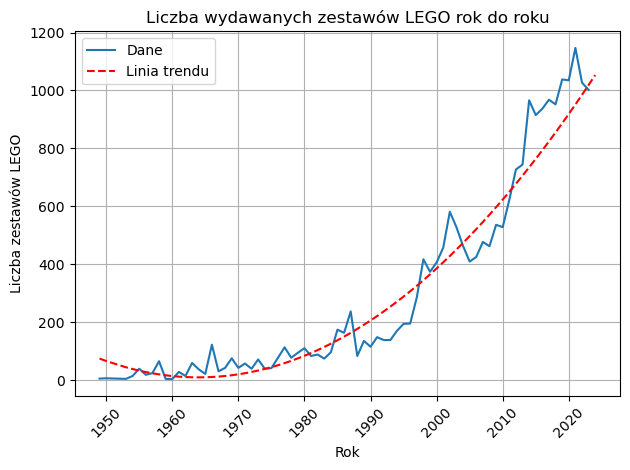

In [71]:
# Number of sets released per year
sets_by_year = sets_themes.groupby("year").size().reset_index(name="set_num")

# Plot actual data
plt.plot(sets_by_year["year"][:-1], sets_by_year["set_num"][:-1], label="Dane")

# Add trend line
trendline = np.polyfit(sets_by_year["year"], sets_by_year["set_num"], 2)
p = np.poly1d(trendline)
plt.plot(sets_by_year["year"], p(sets_by_year["year"]), "r--", label="Linia trendu")

# Configure plot
plt.legend()
plt.title('Liczba wydawanych zestawów LEGO rok do roku')
plt.xlabel("Rok")
plt.ylabel("Liczba zestawów LEGO")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_path / 'liczba_zestawów_rok_do_roku.pdf')
plt.show()

In [72]:
#Sets released per year (table)
sets_by_year_table = sets_themes.groupby("year").count()
sets_by_year_table["set_num"][:-1]

year
1949       5
1950       6
1953       4
1954      14
1955      39
        ... 
2019    1038
2020    1035
2021    1147
2022    1027
2023    1002
Name: set_num, Length: 73, dtype: int64

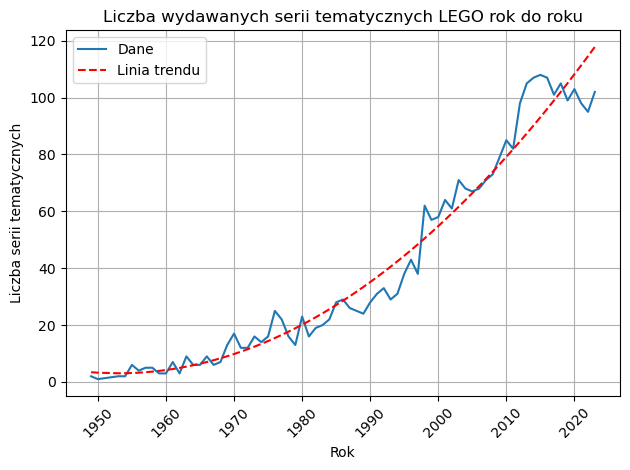

In [73]:
# Number of themes by year
themes_by_year = sets_themes.groupby("year")["theme_id"].nunique().reset_index(name="nr_themes")

# Calculate the trend line
z = np.polyfit(themes_by_year["year"].values[:-1], themes_by_year["nr_themes"].values[:-1], 2)
p = np.poly1d(z)

# Plot the data points and the trend line
plt.plot(themes_by_year["year"].values[:-1], themes_by_year["nr_themes"].values[:-1], label="Dane")
plt.plot(themes_by_year["year"].values[:-1], p(themes_by_year["year"].values[:-1]), "r--", label="Linia trendu")

# Configure the plot
plt.title('Liczba wydawanych serii tematycznych LEGO rok do roku')
plt.xlabel('Rok')
plt.ylabel('Liczba serii tematycznych')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plots_path / 'liczba_serii_rok_do_roku.pdf')
plt.show()

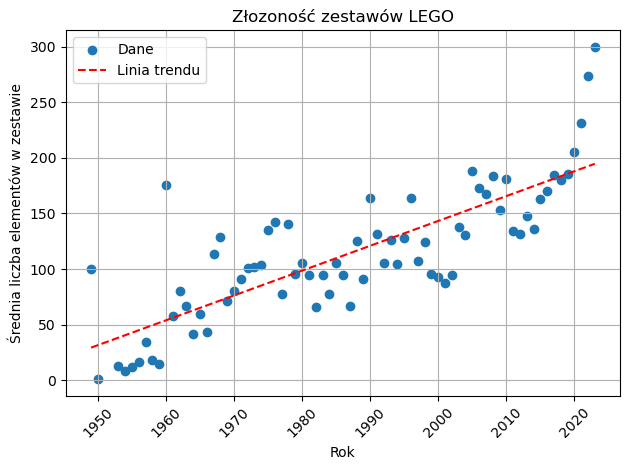

In [74]:
# Complexity trend in LEGO sets per year
# Group the data by year and calculate the average number of parts per set
parts_per_set = sets.groupby('year')['num_parts'].mean()

# Create a scatter plot of the data
plt.scatter(parts_per_set.index[:-1], parts_per_set.values[:-1], label="Dane")

# Calculate the slope and intercept of the best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(parts_per_set.index[:-1], parts_per_set.values[:-1])

# Calculate the x and y values for the best fit line
x = np.array(parts_per_set.index[:-1])
y = intercept + slope * x

# Plot the best fit line
plt.plot(x, y, 'r--', label='Linia trendu')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.title('Złozoność zestawów LEGO')
plt.xlabel('Rok')
plt.ylabel('Średnia liczba elementów w zestawie')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plots_path / 'złozoność_zestawów_rok_do_roku.pdf')
plt.show()

In [75]:
#biggest sets ever per number of parts
sets_themes.sort_values("num_parts", ascending=False).head()


,set_num,name_sets,year,theme_id,num_parts,name_themes
4400,31203-1,World Map,2021,709,11695,LEGO Art
410,10307-1,Eiffel Tower,2022,721,10001,Icons
21063,BIGBOX-1,The Ultimate Battle for Chima,2015,571,9987,Legends of Chima
396,10294-1,Titanic,2021,721,9092,Icons
377,10276-1,Colosseum,2020,721,9036,Icons


### Filtering database:

In [76]:
#filer database
sets_themes = sets_themes.sort_values(by='year')
sets_themes = sets_themes[(sets_themes['year'] >= 1990) & (sets_themes['year'] <= 2023)]
sets_themes = sets_themes[(sets_themes['num_parts'] >= 25)]

#22 most popular themes
themes_to_keep = [252, 610, 52, 621, 22, 608, 579, 494, 246, 721, 603, 576, 577, 155, 693, 435, 601, 158, 684, 596, 690, 453]
sets_themes = sets_themes[sets_themes['theme_id'].isin(themes_to_keep)]

#reset index (number rows ascending)
sets_themes = sets_themes.reset_index(drop=True)

In [77]:
#getting prices from Brickeconomy.com
#save as csv
sets_themes.to_csv(csv_path / 'brickeconomy.csv', index=False)
brickeconomy = pd.read_csv(csv_path / 'brickeconomy.csv')

#prepare csv for brickeconomy format
brickeconomy = brickeconomy.drop(['name_sets','year','theme_id','num_parts','name_themes'], axis='columns')
brickeconomy['quantity']=1
brickeconomy.to_csv(csv_path / 'brickeconomy.csv', index=False)

#read downloaded csv with prices and merge with dataframe
prices = pd.read_csv(csv_path / 'prices.csv', sep=";")
df = pd.merge(sets_themes, prices, how='left', left_on='set_num', right_on='Number')
df = df.drop(['Number', 'Name'], axis='columns')

In [78]:
#filter out rows where any value is missing
df = df.dropna()

#change datatypes
df = df.astype({'Retail': float, 'Value': float})

#filter out rows where Retail is 0
df = df[(df['Retail'] != 0)]

#filter out sets not currently retired
df['Retired'] = df['Retired_date'].str[6:].astype(int)
df = df[(df['Retired'] <= 2023)]
df = df[(df['year'] <= 2020)]
df = df.drop(['Retired'], axis=1)

#reset index
df = df.reset_index(drop=True)
df

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value
0,5110-2,"Cross Axles, Nuts",1990,453,26,Technic,01.01.1996,01.01.1998,9.46,14.95
1,5233-2,Small Beams and Plates with holes,1993,453,26,Technic,01.01.1980,01.01.1982,3.07,14.04
2,5275-1,Toggle Joints and Connectors,1993,453,48,Technic,01.01.1993,01.01.1995,2.86,4.35
3,5286-1,Toggle Joints & Connectors,1994,453,64,Technic,01.01.1994,01.01.1996,3.95,7.62
4,5278-1,TECHNIC Chainlinks,1994,453,35,Technic,01.01.1994,01.01.1996,3.51,11.48
...,...,...,...,...,...,...,...,...,...,...
1616,11009-1,Bricks and Lights,2020,621,441,Classic,01.01.2020,23.03.2022,29.99,31.68
1617,80006-1,White Dragon Horse Bike,2020,693,259,Monkie Kid,16.05.2020,20.05.2022,29.99,35.79
1618,80007-1,Iron Bull Tank,2020,693,430,Monkie Kid,16.05.2020,01.05.2022,44.99,64.93
1619,80009-1,Pigsy's Food Truck,2020,693,832,Monkie Kid,16.05.2020,01.11.2021,59.99,97.17


In [79]:
df.describe()

,year,theme_id,num_parts,Retail,Value
count,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000
mean,2014.366440,348.342998,363.859346,36.473529,109.809192
std,5.333121,196.896506,475.561476,40.196117,228.287948
min,1990.000000,22.000000,25.000000,1.750000,3.770000
25%,2012.000000,158.000000,91.000000,9.990000,22.550000
50%,2016.000000,435.000000,212.000000,24.990000,52.250000
75%,2018.000000,494.000000,468.000000,49.990000,118.440000
max,2020.000000,721.000000,9036.000000,549.990000,5517.540000


### HPR and APR:

In [80]:
#create new columns (HPR, HPY, APR)
df['HPR'] = (df['Value'] - df['Retail']) / df['Retail']
df['APR'] = ((df['HPR'] + 1) ** (1/(2024 - df['year']))) - 1
#save as csv
df.to_csv(csv_path / 'LEGO_database.csv')

df

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value,HPR,APR
0,5110-2,"Cross Axles, Nuts",1990,453,26,Technic,01.01.1996,01.01.1998,9.46,14.95,0.580338,0.013551
1,5233-2,Small Beams and Plates with holes,1993,453,26,Technic,01.01.1980,01.01.1982,3.07,14.04,3.573290,0.050262
2,5275-1,Toggle Joints and Connectors,1993,453,48,Technic,01.01.1993,01.01.1995,2.86,4.35,0.520979,0.013619
3,5286-1,Toggle Joints & Connectors,1994,453,64,Technic,01.01.1994,01.01.1996,3.95,7.62,0.929114,0.022144
4,5278-1,TECHNIC Chainlinks,1994,453,35,Technic,01.01.1994,01.01.1996,3.51,11.48,2.270655,0.040290
...,...,...,...,...,...,...,...,...,...,...,...,...
1616,11009-1,Bricks and Lights,2020,621,441,Classic,01.01.2020,23.03.2022,29.99,31.68,0.056352,0.013800
1617,80006-1,White Dragon Horse Bike,2020,693,259,Monkie Kid,16.05.2020,20.05.2022,29.99,35.79,0.193398,0.045193
1618,80007-1,Iron Bull Tank,2020,693,430,Monkie Kid,16.05.2020,01.05.2022,44.99,64.93,0.443210,0.096055
1619,80009-1,Pigsy's Food Truck,2020,693,832,Monkie Kid,16.05.2020,01.11.2021,59.99,97.17,0.619770,0.128141


In [81]:
#average APR per year
APR_yearly = df.groupby("year").mean('APR')
print(APR_yearly['APR'].tail(10))

year
2011    0.098861
2012    0.090989
2013    0.086724
2014    0.092288
2015    0.090487
2016    0.088838
2017    0.104118
2018    0.104216
2019    0.084523
2020    0.060056
Name: APR, dtype: float64


In [82]:
APR_mean = round(df['APR'].mean(), 6)
APR_mean

0.089975

In [83]:
APR_by_themes = df.groupby("name_themes").mean('APR')
APR_by_themes = APR_by_themes.sort_values("APR", ascending=False)
APR_by_themes['APR']

name_themes
Brickheadz               0.195140
Scooby-Doo               0.153368
Speed Champions          0.129584
Ninjago                  0.119848
Architecture             0.113929
Modular Buildings        0.101081
Super Mario              0.095400
Star Wars                0.094977
Creator                  0.085403
Marvel Super Heroes      0.083764
LEGO Ideas and CUUSOO    0.082574
Minecraft                0.080513
Harry Potter             0.068763
Disney Princess          0.068475
City                     0.054979
Monkie Kid               0.053890
Friends                  0.049228
Classic                  0.037179
Icons                    0.029209
Technic                  0.029062
Disney                   0.001608
Name: APR, dtype: float64

In [102]:
# Assuming df is your DataFrame and it has two columns: 'num_elements' and 'annual_return'
df['group'] = pd.cut(df['num_parts'], bins=[0, 250, 500, float('inf')], labels=['small', 'medium', 'big'])

# Calculate the average annual return for each group
grouped = df.groupby('group')['APR'].mean()

# Print the most profitable group
round(grouped, 3)

group
small     0.097
medium    0.085
big       0.076
Name: APR, dtype: float64

In [85]:
#highest APR values
df.sort_values("APR", ascending=False).head(10)

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value,HPR,APR,group
1367,41636-1,Benny,2019,610,103,Brickheadz,01.02.2019,19.02.2019,8.79,132.13,14.031854,0.719501,small
1309,77901-1,Sith Trooper Bust,2019,158,484,Star Wars,18.07.2019,21.07.2019,39.60,525.24,12.263636,0.676998,medium
1220,75188-2,Resistance Bomber (Finch Dallow version),2018,158,780,Star Wars,01.05.2019,27.07.2019,109.99,1759.41,14.996091,0.587336,big
1365,41634-1,Emmet,2019,610,113,Brickheadz,02.01.2019,01.02.2019,13.19,114.40,7.673237,0.540410,small
984,41497-1,Spider-Man & Venom,2017,610,144,Brickheadz,20.07.2017,22.07.2017,39.99,720.70,17.022006,0.511473,small
827,41491-1,Batman & The Joker,2016,610,206,Brickheadz,21.07.2016,21.07.2016,39.99,1033.92,24.854464,0.501644,small
1368,41637-1,Sweet Mayhem,2019,610,137,Brickheadz,01.02.2019,19.02.2019,8.79,64.89,6.382253,0.491550,small
829,41493-1,Black Panther & Dr. Strange,2016,610,167,Brickheadz,22.07.2016,22.07.2016,39.99,940.47,22.517629,0.483967,small
1366,41635-1,Wyldstyle,2019,610,134,Brickheadz,02.01.2019,01.02.2019,13.19,87.99,5.670963,0.461631,small
826,41490-1,Superman & Wonder Woman,2016,610,210,Brickheadz,23.07.2016,23.07.2016,39.99,812.06,19.306577,0.456983,small


In [86]:
#lowest APR values
df.sort_values("APR", ascending=True).head(10)

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value,HPR,APR,group
1432,71368-1,Toad's Treasure Hunt Expansion Set,2020,690,465,Super Mario,02.08.2020,10.08.2022,79.99,58.08,-0.273909,-0.076902,medium
1592,75318-1,The Child,2020,158,1073,Star Wars,23.09.2020,31.12.2023,89.99,65.99,-0.266696,-0.074618,big
1433,71367-1,Mario's House & Yoshi Expansion Set,2020,690,206,Super Mario,02.08.2020,01.01.2023,29.99,22.00,-0.266422,-0.074532,small
1336,75254-1,AT-ST Raider,2019,158,540,Star Wars,04.10.2019,23.03.2022,59.99,43.96,-0.267211,-0.060286,big
1262,21319-1,Central Perk,2019,576,1070,LEGO Ideas and CUUSOO,01.09.2019,21.11.2022,79.99,61.22,-0.234654,-0.052080,big
1338,75250-1,Pasaana Speeder Chase,2019,158,373,Star Wars,04.10.2019,20.07.2021,49.99,38.29,-0.234047,-0.051930,medium
1459,75292-1,The Razor Crest,2020,158,1023,Star Wars,01.09.2020,20.11.2023,139.99,114.40,-0.182799,-0.049215,big
1356,75893-1,2018 Dodge Challenger SRT Demon and 1970 Dodge...,2019,601,485,Speed Champions,02.01.2019,10.07.2021,39.99,31.36,-0.215804,-0.047456,medium
1511,60271-1,Main Square,2020,52,1517,City,01.09.2020,01.01.2022,175.45,145.95,-0.168139,-0.044980,big
1033,75176-1,Resistance Transport Pod,2017,158,294,Star Wars,02.09.2017,01.04.2019,39.99,29.22,-0.269317,-0.043835,medium


### Other instuments data:

[*********************100%%**********************]  3 of 3 completed


,BTC-USD,DAX,SP500,Gold
Date,,,,
2023-08-31,25931.472656,15947.080078,4507.660156,1940.095
2023-09-30,26967.916016,15386.580078,4288.049805,1848.490
2023-10-31,34667.781250,14810.339844,4193.799805,1984.650
2023-11-30,37712.746094,16215.429688,4567.799805,2036.195
2023-12-31,42156.902344,16751.640625,4769.830078,2063.235


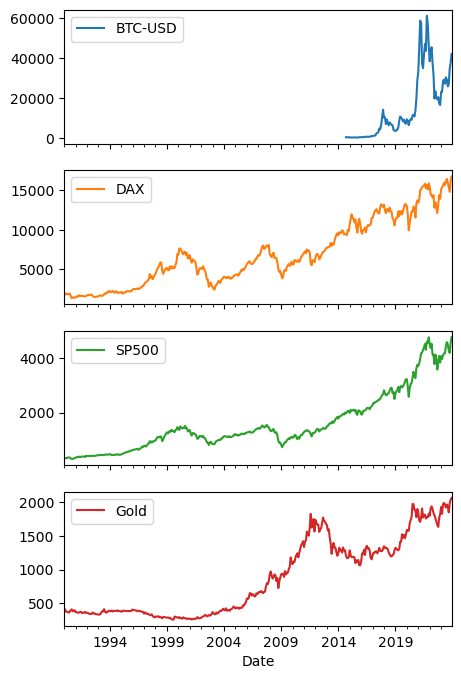

In [87]:
yf.pdr_override()
other_instruments = pdr.get_data_yahoo(["^GSPC", "^GDAXI", "BTC-USD"], start="1990-01-01", end="2023-12-31")
other_instruments = other_instruments.resample('M').last()
other_instruments = other_instruments['Close']
other_instruments = other_instruments.rename(columns={'^GSPC': 'SP500', 'WIG20.WA': 'WIG20', '^GDAXI': 'DAX'})
gold_historical_data = pd.read_csv(csv_path / 'xauusd.csv')
other_instruments = other_instruments.reset_index()
other_instruments = other_instruments.join(gold_historical_data['Close'])
other_instruments = other_instruments.rename(columns={'Close': 'Gold'})

#Set 'Date' as index
other_instruments.set_index("Date", inplace=True)
other_instruments.plot(figsize=(5,8), subplots=True)
plt.savefig(plots_path / 'szeregi_długie_wszystkie.pdf')

other_instruments.tail()

In [88]:
HPR_SP500 = (((other_instruments['SP500'].iloc[-1] - other_instruments['SP500'].iloc[0]) / other_instruments['SP500'].iloc[0]))
APR_SP500 = round(((HPR_SP500 + 1) ** (1/34)) - 1, 6)

HPR_DAX = (((other_instruments['DAX'].iloc[-1] - other_instruments['DAX'].iloc[0]) / other_instruments['DAX'].iloc[0]))
APR_DAX = round(((HPR_DAX + 1) ** (1/34)) - 1, 6)

HPR_Gold = (((other_instruments['Gold'].iloc[-1] - other_instruments['Gold'].iloc[0]) / other_instruments['Gold'].iloc[0]))
APR_Gold = round(((HPR_Gold + 1) ** (1/34)) - 1, 6)

HPR_BTC = ((other_instruments['BTC-USD'].iloc[-1] - other_instruments['BTC-USD'].iloc[300]) / other_instruments['BTC-USD'].iloc[300])
APR_BTC = round(((HPR_BTC + 1) ** (1/9)) - 1, 6)

In [89]:
print(f'APR for SP500: {APR_SP500}')
print(f'APR for DAX: {APR_DAX}')
print(f'APR for Gold: {APR_Gold}')
print(f'APR for BTC: {APR_BTC}')
print(f'APR for LEGO: {APR_mean}')

APR for SP500: 0.081815
APR for DAX: 0.067441
APR for Gold: 0.048092
APR for BTC: 0.795414
APR for LEGO: 0.089975
